In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#!unrar x "/content/gdrive/MyDrive/Deep Learning/PlantDoc_cropped.rar"

import zipfile

#zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Deep Learning/archive.zip", 'r')
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Transfer learning for PlantDoc/Merged_PlantDoc2_Augmented.zip",'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

import torchvision.models as models

%matplotlib inline

In [4]:
!pip install mlflow

     |████████████████████████████████| 14.2MB 10.5MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 1.1MB 56.1MB/s 
     |████████████████████████████████| 645kB 43.1MB/s 
     |████████████████████████████████| 153kB 64.6MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 174kB 55.0MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.14.3-cp37-none-any.whl size=100560 sha256=3c4d07582f21b0b9abc872f82e6ad1abe80d258bf3f41dd96455540f67367201
  Stored in directory: /root/.cache/pip/wheels/5b/24/f3/34d8e3964dac4ba849d844273c49a679111b00d5799ebb934a
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158170 sha256=517499484c82ea3523ab8d7a95adf3d3bc13caeafd7db52e4a875b7ac5c63304
  Stored in 

In [5]:
import mlflow
import mlflow.pytorch

## Data Load

In [6]:
data_dir = "/content/Merged_PlantDoc2_Augmented"
diseases = os.listdir(data_dir)
print(diseases)

['Potato leaf early blight', 'Bell_pepper leaf spot', 'Tomato mold leaf', 'Potato leaf late blight', 'Apple leaf', 'Tomato Early blight leaf', 'Tomato leaf mosaic virus', 'Apple Scab Leaf', 'Tomato leaf', 'Corn leaf blight', 'Cherry leaf', 'Corn rust leaf', 'Soyabean leaf', 'Tomato leaf bacterial spot', 'Strawberry leaf', 'grape leaf black rot', 'grape leaf', 'Tomato leaf yellow virus', 'Corn Gray leaf spot', 'Bell_pepper leaf', 'Apple rust leaf', 'Tomato leaf late blight', 'Raspberry leaf', 'Peach leaf', 'Tomato Septoria leaf spot', 'Blueberry leaf', 'Squash Powdery mildew leaf']


In [7]:
print("Total disease classes are:", len(diseases))

Total disease classes are: 27


In [8]:
# Number of images for each disease
nums = {}
nums2 = {}
for disease in diseases:
    nums[disease] = len(os.listdir(data_dir+'/'+ disease))
    
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
print(img_per_class)

                            no. of images
Potato leaf early blight              862
Bell_pepper leaf spot                 789
Tomato mold leaf                      879
Potato leaf late blight               747
Apple leaf                            741
Tomato Early blight leaf              852
Tomato leaf mosaic virus              783
Apple Scab Leaf                       855
Tomato leaf                           792
Corn leaf blight                      834
Cherry leaf                           717
Corn rust leaf                        889
Soyabean leaf                         798
Tomato leaf bacterial spot            840
Strawberry leaf                       842
grape leaf black rot                  798
grape leaf                            880
Tomato leaf yellow virus              829
Corn Gray leaf spot                   780
Bell_pepper leaf                      846
Apple rust leaf                       890
Tomato leaf late blight               880
Raspberry leaf                    

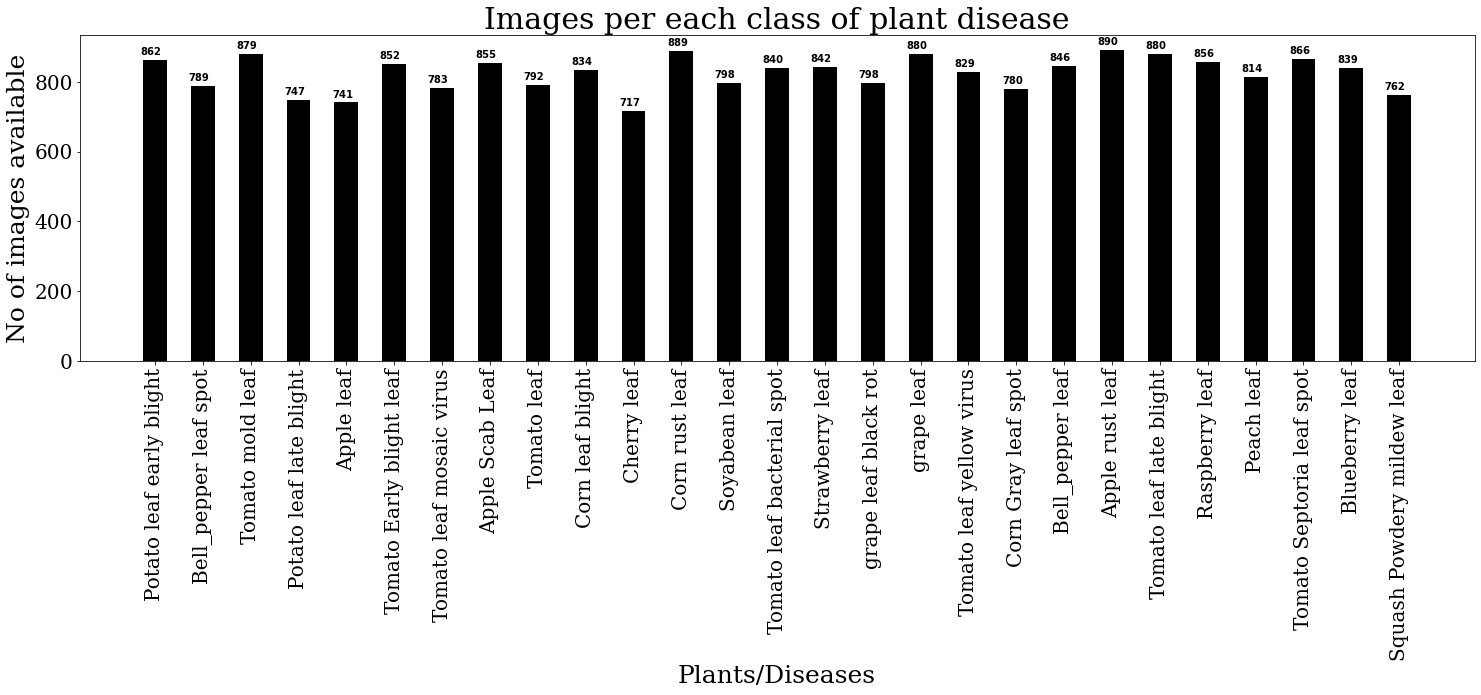

In [9]:
# plotting number of images available for each disease
from matplotlib import rc
index = [n for n in range(len(diseases))]
plt.figure(figsize=(25, 6))
plt.bar(index, [n for n in nums.values()], width=0.5, color = ['black'])
#rc('font',**{'family':'serif','serif':['Times']})
plt.xlabel('Plants/Diseases', fontsize=25, fontname = 'serif')
plt.ylabel('No of images available', fontsize=25, fontname = 'serif')
plt.xticks(index, diseases, fontsize=20, fontname = 'serif',rotation=90)
plt.yticks(fontsize = 20, fontname = 'serif')
plt.title('Images per each class of plant disease', fontsize = 30, fontname = 'serif')
for i, v in enumerate(nums.values()):
    plt.text( i-0.3,v+15, str(v), fontweight = 'bold')

In [10]:
total_imgs = img_per_class["no. of images"].sum()

print(total_imgs)
#8921 (github repo (csv))  #2598 images for object detection dataset (xml) but after cropping, got 8872 images only, #in paper (9216) => for C-PD, 

22260


In [11]:
# datasets for validation and training
siz = 224  
transform1 = transforms.Compose([transforms.Resize((siz,siz)),transforms.ToTensor()])
data = ImageFolder(data_dir, transform=transform1)
data.classes

['Apple Scab Leaf',
 'Apple leaf',
 'Apple rust leaf',
 'Bell_pepper leaf',
 'Bell_pepper leaf spot',
 'Blueberry leaf',
 'Cherry leaf',
 'Corn Gray leaf spot',
 'Corn leaf blight',
 'Corn rust leaf',
 'Peach leaf',
 'Potato leaf early blight',
 'Potato leaf late blight',
 'Raspberry leaf',
 'Soyabean leaf',
 'Squash Powdery mildew leaf',
 'Strawberry leaf',
 'Tomato Early blight leaf',
 'Tomato Septoria leaf spot',
 'Tomato leaf',
 'Tomato leaf bacterial spot',
 'Tomato leaf late blight',
 'Tomato leaf mosaic virus',
 'Tomato leaf yellow virus',
 'Tomato mold leaf',
 'grape leaf',
 'grape leaf black rot']

In [12]:
img, label = data[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 0


In [13]:
# for checking some images from training dataset
def show_image(image, label):
    #print("Label :" + train.classes[label] + "(" + str(label) + ")")
    print("Label :" + data.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Apple Scab Leaf(0)


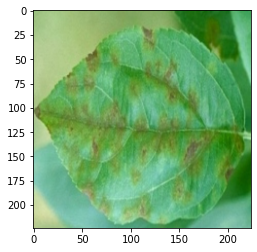

In [14]:
show_image(*data[0])

In [15]:
random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

In [16]:
class Params(object):
    def __init__(self, batch_size, epochs,lr = 0.001,grad_clip = None, weight_decay = 0,
                 momentum = 0.9, opt_func = torch.optim.SGD):
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.grad_clip = grad_clip
        self.weight_decay = weight_decay
        self.opt_func = opt_func
        self.momentum = momentum

In [17]:
args = Params(batch_size = 32, epochs = 25)

In [18]:
data_dl = DataLoader(data, args.batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [19]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [20]:
show_batch(data_dl) 

Output hidden; open in https://colab.research.google.com to view.

# Split


In [21]:
num_train = int(total_imgs*0.7) +1
num_val = int(total_imgs*0.1)
num_test = int(total_imgs*0.2) 

print(num_train+num_val+num_test)

train_ds, valid_ds, test_ds = torch.utils.data.random_split(data_dl.dataset,(num_train,num_val,num_test))

22260


In [22]:
print(len(train_ds.indices),len(test_ds),len(valid_ds))

15582 4452 2226


In [23]:
train_dl = DataLoader(train_ds, args.batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, args.batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, args.batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [24]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
data_dl = DeviceDataLoader(data_dl,device)

# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl,device)


## Model

#AlexNet pretrained on ImageNet + PDI

In [ ]:
#!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelAlexNet_TL-PDI.pth /content

In [27]:
model = torch.load('/content/gdrive/MyDrive/Transfer learning for PlantDoc/Saved models_(Imagenet-PDI)epochs=12,WD=0.003/Alexnetmodel_ImagenetToPDI.pth')
#model = torch.load('/content/gdrive/MyDrive/mlruns for PDI /All trained models (PDI)/model_25.pth')


In [ ]:
#model = torch.load('/content/gdrive/MyDrive/Saved Models/model_25.pth') #AlexNet 25 epochs
#model3 = torch.load('/content/model_30.pth') #AlexNet 30 epochs
#model4 = torch.load('/content/model_ZFNet_25.pth')  #ZFNet 25 epochs
#model5 = torch.load('/content/modelVGGNet_11_25.pth')  #VGG11 25 epochs
#model = torch.load('/content/gdrive/MyDrive/Saved Models/modelVGG_13_25.pth')  #VGG13 25 epochs
#model7 = torch.load('/content/modelVGG_16_25.pth')  #VGG16 25 epochs
#model8 = torch.load('/content/modelVGG_19_25.pth')  #VGG19 25 epochs
#model = torch.load('/content/gdrive/MyDrive/Saved Models/GoogleNet_0.001_25_model.pth')

#model = models.googlenet(pretrained=True)

In [28]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
model.classifier[6] = nn.Linear(4096,len(diseases),bias = True)
#model.linear[6] = nn.Linear(4096,len(diseases),bias = True)

In [ ]:
# Freeze model parameters
#for param in model.parameters():
 #   param.requires_grad = False

In [ ]:
#model.fc = nn.Linear(1024,len(diseases),bias = True)

In [31]:
model = to_device(model, device) 
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#ZFNet pretrained on PDI

In [ ]:
model = torch.load('/content/gdrive/MyDrive/mlruns for PDI /All trained models (PDI)/model_ZFNet_25.pth')
model

ZFNet(
  (convolutional): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=18432, out_features=4096, bias=True)
    (2): ReLU(inp

In [ ]:
model.linear[6] = nn.Linear(4096,len(diseases),bias = True)

In [ ]:
model = to_device(model, device) 
model

ZFNet(
  (convolutional): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=18432, out_features=4096, bias=True)
    (2): ReLU(inp

#GoogleNet pretrained on ImageNet + PDI

In [ ]:
#!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models_\(Imagenet-PDI\)/modelGoogLeNet_TL-PDI.pth /content

In [27]:
model = torch.load('/content/gdrive/MyDrive/Transfer learning for PlantDoc/Saved models_(Imagenet-PDI)epochs=12,WD=0.003/Googlenetmodel_ImagenetToPDI.pth')
#model = torch.load('/content/gdrive/MyDrive/mlruns for PDI /All trained models (PDI)/GoogleNet_0.001_25_model.pth')
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
#model = torch.load('/content/gdrive/MyDrive/Transfer learning for PlantDoc/Saved models_(Imagenet-PDI)/modelGoogLeNet_TL-PDI.pth')
#model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
#model = torch.load('/content/modelGoogLeNet_TL-PDI.pth')
#model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
# Freeze model parameters
#for param in model.parameters():
 #   param.requires_grad = False

In [28]:
model.fc = nn.Linear(1024,len(diseases),bias = True)
#model.fc1 = nn.Linear(1024,len(diseases),bias = True)

In [29]:
model = to_device(model, device) 
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

#VGG11 pretrained on ImageNet + PDI

In [ ]:
#!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelVGG11_TL-PDI.pth /content

In [27]:
model = torch.load('/content/gdrive/MyDrive/Transfer learning for PlantDoc/Saved models_(Imagenet-PDI)epochs=12,WD=0.003/VGG11model_ImagenetToPDI.pth')

#model = torch.load('/content/gdrive/MyDrive/mlruns for PDI /All trained models (PDI)/modelVGGNet_11_25.pth')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [28]:
#model.fcs[6] = nn.Linear(4096,len(diseases),bias = True)
model.classifier[6] = nn.Linear(4096,len(diseases),bias = True)

In [29]:
model = to_device(model, device) 
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

#VGG13 pretrained on ImageNet + PDI

In [ ]:
#!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelVGG13_TL-PDI.pth /content

In [27]:
#model = torch.load('/content/gdrive/MyDrive/mlruns for PDI /All trained models (PDI)/modelVGG_13_25.pth')
model = torch.load('/content/gdrive/MyDrive/Transfer learning for PlantDoc/Saved models_(Imagenet-PDI)epochs=12,WD=0.003/VGG13model_ImagenetToPDI.pth')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [28]:
model.classifier[6] = nn.Linear(4096,len(diseases),bias = True)
#model.fcs[6] = nn.Linear(4096,len(diseases),bias = True)

In [29]:
model = to_device(model, device) 
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#VGG16 pretrained on ImageNet + PDI

In [ ]:
#!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelVGG16_TL-PDI.pth /content

In [27]:
model = torch.load('/content/gdrive/MyDrive/Transfer learning for PlantDoc/Saved models_(Imagenet-PDI)epochs=12,WD=0.003/VGG16model_ImagenetToPDI.pth')
#model = torch.load('/content/gdrive/MyDrive/mlruns for PDI /All trained models (PDI)/modelVGG_16_25.pth')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [28]:
model.classifier[6] = nn.Linear(4096,len(diseases),bias = True)
#model.fcs[6] = nn.Linear(4096,len(diseases),bias = True)

In [29]:
model = to_device(model, device) 
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#VGG19 pretrained on ImageNet + PDI

In [ ]:
#!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelVGG19_TL-PDI.pth /content

In [27]:
model = torch.load('/content/gdrive/MyDrive/Transfer learning for PlantDoc/Saved models_(Imagenet-PDI)epochs=12,WD=0.003/VGG19model_ImagenetToPDI.pth')
#model = torch.load('/content/gdrive/MyDrive/mlruns for PDI /All trained models (PDI)/modelVGG_19_25.pth')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [28]:
model.classifier[6] = nn.Linear(4096,len(diseases),bias = True)
#model.fcs[6] = nn.Linear(4096,len(diseases),bias = True)

In [29]:
model = to_device(model, device) 
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#ResNet50 pretrained on ImageNet + PDI

In [ ]:
#!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelResNet50_TL-PDI.pth /content

In [27]:
model = torch.load('/content/gdrive/MyDrive/Transfer learning for PlantDoc/Saved models_(Imagenet-PDI)epochs=12,WD=0.003/Resnet50model_ImagenetToPDI.pth')
#model = torch.load('/content/gdrive/MyDrive/mlruns for PDI /All trained models (PDI)/modelResNet50_25.pth')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
model.fc = nn.Linear(2048,len(diseases),bias = True)

In [29]:
model = to_device(model, device) 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#ResNet101 pretrained on ImageNet + PDI

In [ ]:
#!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelResNet101_TL-PDI.pth /content

In [27]:
model = torch.load('/content/gdrive/MyDrive/Transfer learning for PlantDoc/Saved models_(Imagenet-PDI)epochs=12,WD=0.003/Resnet101model_ImagenetToPDI.pth')
#model = torch.load('/content/gdrive/MyDrive/mlruns for PDI /All trained models (PDI)/modelResNet101.pth')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
model.fc = nn.Linear(2048,len(diseases),bias = True)

In [29]:
model = to_device(model, device) 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#ResNet152 pretrained on ImageNet + PDI

In [ ]:
#!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelResNet152_TL-PDI.pth /content

In [27]:
model = torch.load('/content/gdrive/MyDrive/Transfer learning for PlantDoc/Saved models_(Imagenet-PDI)epochs=12,WD=0.003/Resnet152model_ImagenetToPDI.pth')
#model = torch.load('/content/gdrive/MyDrive/mlruns for PDI /All trained models (PDI)/modelResnet152_25.pth')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
model.fc = nn.Linear(2048,len(diseases),bias = True)

In [29]:
model = to_device(model, device) 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#Training

In [30]:
%xmode Verbose

Exception reporting mode: Verbose


In [31]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
def training_step(model, batch):
    images, labels = batch
    out = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

def validation_step(model, batch):
    images, labels = batch
    out = model(images)                   # Generate prediction
    loss = F.cross_entropy(out, labels)  # Calculate loss
    acc = accuracy(out, labels)          # Calculate accuracy
    return {"val_loss": loss.detach(), "val_accuracy": acc}

def validation_epoch_end(model, outputs,log = False,loss = "loss", accuracy = "accuracy"):
    batch_losses = [x["val_loss"] for x in outputs]
    batch_accuracy = [x["val_accuracy"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
    epoch_accuracy = torch.stack(batch_accuracy).mean()
    if log:
        mlflow.log_metric(loss,epoch_loss.data.item())
        mlflow.log_metric(accuracy,epoch_accuracy.data.item())
    return {"loss": epoch_loss, "accuracy": epoch_accuracy} # Combine accuracies

def epoch_end(model, epoch, result):
    pass
   

In [32]:
# for training
@torch.no_grad()
def evaluate(model, val_loader,log = False, loss = "loss", accuracy = "accuracy"):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(model,outputs,log,loss,accuracy)


def fit(epochs, lr, model, train_loader, val_loader,  weight_decay=0,grad_clip=None,
        momentum = 0.9, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay,
                         momentum = momentum)
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
       
        for batch in train_loader:
            loss = training_step(model,batch)
            train_losses.append(loss)
            #mlflow.log_metric('training_loss', loss.data.item())
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
        #validation
        result = evaluate(model, val_loader, True, 'val_loss', 'val_accuracy')
        train_result = evaluate(model, train_loader, True, 'train_loss', 'train_accuracy')
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, train_result['loss'], train_result['accuracy'], result['loss'], result['accuracy']))
        #history.append(result.cpu())

        #with tune.checkpoint_dir(epoch) as checkpoint_dir:
            #path = os.path.join(checkpoint_dir, "checkpoint")
            #torch.save((net.state_dict(), optimizer.state_dict()), path)

        #tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
        


In [33]:
def get_all_preds(model,loader):
    all_preds = torch.tensor([])
    true_lb = torch.tensor([])
    #all_preds = all_preds.cuda()
    #print(all_preds.is_cuda)
    #print(type(all_preds))
    
    for batch in loader:       
        torch.cuda.empty_cache() 
        with torch.no_grad():
            
            images,labels = batch
            preds = model(images)
            
            preds = preds.cpu()
            all_preds = torch.cat((all_preds,preds),dim=0)
            true_lb = torch.cat((true_lb,labels.cpu()),dim=0)

    print(true_lb)
    print(all_preds.argmax(dim=1))      
    return all_preds.argmax(dim=1),true_lb

In [36]:
%%time
history = [evaluate(model, valid_dl)]
print(history)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'loss': tensor(3.3888, device='cuda:0'), 'accuracy': tensor(0.0406)}]
CPU times: user 767 ms, sys: 425 ms, total: 1.19 s
Wall time: 9.97 s


In [34]:
%%time
history = [evaluate(model, data_dl)]
print(history)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'loss': tensor(3.3244, device='cuda:0'), 'accuracy': tensor(0.0251)}]
CPU times: user 37.9 s, sys: 2.97 s, total: 40.9 s
Wall time: 1min 28s


In [34]:
from sklearn import metrics

In [35]:
expt_id = mlflow.create_experiment('AugVGG16_ImagenetPDItoCPD_TL')   
mlflow.set_experiment('AugVGG16_ImagenetPDItoCPD_TL')  #Transfer Learning: AlexNet_PDItoCPD_TL, GoogleNet_PDItoCPD_TL, VGG16_PDItoCPD_TL, VGG13_PDItoCPD_TL, VGG11_PDItoCPD_TL, VGG19_PDItoCPD_TL, ResNet50_PDItoCPD_TL, ResNet101_PDItoCPD_TL, ResNet152_PDItoCPD_TL
args.grad_clip = None                           #AugGoogleNet_PDItoCPD_TL, AugAlexNet_PDItoCPD_TL, AugZFNet_PDItoCPD_TL, AugVGG11_PDItoCPD_TL, AugResNet50_PDItoCPD_TL, AugResNet101_PDItoCPD_TL, AugResNet152_PDItoCPD_TL, AugVGG13_PDItoCPD_TL, AugVGG16_PDItoCPD_TL, AugVGG19_PDItoCPD_TL
args.weight_decay = 0.0005       #0.002         #AugAlexNet_ImagenetPDItoCPD_TL, AugGoogleNet_ImagenetPDItoCPD_TL, AugVGG11_ImagenetPDItoCPD_TL, AugVGG16_ImagenetPDItoCPD_TL, AugVGG13_ImagenetPDItoCPD_TL, AugVGG19_ImagenetPDItoCPD_TL, AugResNet50_ImagenetPDItoCPD_TL, AugResNet101_ImagenetPDItoCPD_TL, AugResNet152_ImagenetPDItoCPD_TL
#args.opt_func = opt_func
#args.momentum = 0.9

for lr in [0.001]:
    for epochs in [25]:
        for momentum in [0.9]:
            #model = to_device(GoogleNet(3, len(data.classes)), device)
            with mlflow.start_run() as run:
                args.epochs = epochs
                args.lr = lr
                args.momentum = momentum
                print("lr:", args.lr, " epochs:", args.epochs, " momentum:", args.momentum)
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
          
                fit(args.epochs, args.lr, model, train_dl, valid_dl, grad_clip=args.grad_clip, weight_decay= args.weight_decay, momentum = args.momentum, opt_func=args.opt_func)

                test_acc = evaluate(model, test_dl,True,'test_loss', 'test_accuracy')
                print(test_acc)
                #save_confusion_matrix(model,test_dl)
            
                data_preds,true_lb = get_all_preds(model,test_dl)

                y_true = true_lb.tolist()
                y_pred = data_preds.tolist()

                # Print the confusion matrix
                #print(metrics.confusion_matrix(y_true, y_pred))

                # Print the precision and recall, among other metrics
                report = metrics.classification_report(y_true, y_pred, digits=3)
                print(report)
                # mlflow.log_metric('f1-score', report['macro avg']['f1-score'])
                mlflow.pytorch.log_model(model, "models")



lr: 0.001  epochs: 25  momentum: 0.9


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [0], train_loss: 0.7799, train_acc: 0.7385, val_loss: 0.9682, val_acc: 0.6745
Epoch [1], train_loss: 0.5806, train_acc: 0.8131, val_loss: 0.9150, val_acc: 0.7227
Epoch [2], train_loss: 0.2723, train_acc: 0.9061, val_loss: 0.6506, val_acc: 0.7849
Epoch [3], train_loss: 0.1440, train_acc: 0.9560, val_loss: 0.5969, val_acc: 0.8111
Epoch [4], train_loss: 0.1169, train_acc: 0.9646, val_loss: 0.6245, val_acc: 0.8092
Epoch [5], train_loss: 0.1236, train_acc: 0.9597, val_loss: 0.7016, val_acc: 0.7974
Epoch [6], train_loss: 0.0467, train_acc: 0.9854, val_loss: 0.5922, val_acc: 0.8281
Epoch [7], train_loss: 0.0338, train_acc: 0.9910, val_loss: 0.6028, val_acc: 0.8329
Epoch [8], train_loss: 0.0278, train_acc: 0.9930, val_loss: 0.6122, val_acc: 0.8409
Epoch [9], train_loss: 0.0265, train_acc: 0.9932, val_loss: 0.6316, val_acc: 0.8370
Epoch [10], train_loss: 0.0393, train_acc: 0.9875, val_loss: 0.7468, val_acc: 0.8258
Epoch [11], train_loss: 0.0314, train_acc: 0.9905, val_loss: 0.6023, val_ac

In [36]:
#!zip -r /content/mlrunsAugAlexNet_TL_ImagenetPDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugGoogleNet_TL_ImagenetPDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugVGG11_TL_ImagenetPDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugVGG13_TL_ImagenetPDItoCPD.zip /content/mlruns   
!zip -r /content/mlrunsAugVGG16_TL_ImagenetPDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugResnet50_TL_ImagenetPDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugResnet101_TL_ImagenetPDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugResnet152_TL_ImagenetPDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugVGG19_TL_ImagenetPDItoCPD.zip /content/mlruns   

#!zip -r /content/mlrunsAugAlexNet_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugZFNet_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugVGG11_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugGoogleNet_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugResNet50_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugResNet101_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugResNet152_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugVGG13_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugVGG16_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsAugVGG19_TL_PDItoCPD.zip /content/mlruns   

#!zip -r /content/mlrunsVGG16_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsVGG13_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsVGG11_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsVGG19_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsResNet50_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsResNet101_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsResNet152_TL_PDItoCPD.zip /content/mlruns   
#!zip -r /content/mlrunsGoogleNet_TL_PDItoCPD\(lastlayer\).zip /content/mlruns  

  adding: content/mlruns/ (stored 0%)
  adding: content/mlruns/0/ (stored 0%)
  adding: content/mlruns/0/meta.yaml (deflated 11%)
  adding: content/mlruns/1/ (stored 0%)
  adding: content/mlruns/1/299efdec61e34bac821daab4262b7af0/ (stored 0%)
  adding: content/mlruns/1/299efdec61e34bac821daab4262b7af0/metrics/ (stored 0%)
  adding: content/mlruns/1/299efdec61e34bac821daab4262b7af0/metrics/val_loss (deflated 58%)
  adding: content/mlruns/1/299efdec61e34bac821daab4262b7af0/metrics/train_loss (deflated 58%)
  adding: content/mlruns/1/299efdec61e34bac821daab4262b7af0/metrics/train_accuracy (deflated 60%)
  adding: content/mlruns/1/299efdec61e34bac821daab4262b7af0/metrics/test_loss (stored 0%)
  adding: content/mlruns/1/299efdec61e34bac821daab4262b7af0/metrics/val_accuracy (deflated 58%)
  adding: content/mlruns/1/299efdec61e34bac821daab4262b7af0/metrics/test_accuracy (stored 0%)
  adding: content/mlruns/1/299efdec61e34bac821daab4262b7af0/artifacts/ (stored 0%)
  adding: content/mlruns/1/29

In [37]:
#!cp /content/mlrunsAugAlexNet_TL_ImagenetPDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugGoogleNet_TL_ImagenetPDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugVGG11_TL_ImagenetPDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugVGG13_TL_ImagenetPDItoCPD.zip /content/gdrive/MyDrive
!cp /content/mlrunsAugVGG16_TL_ImagenetPDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugResnet50_TL_ImagenetPDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugResnet101_TL_ImagenetPDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugResnet152_TL_ImagenetPDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugVGG19_TL_ImagenetPDItoCPD.zip /content/gdrive/MyDrive

#!cp /content/mlrunsAugAlexNet_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugZFNet_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugVGG11_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugGoogleNet_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugResNet50_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugResNet101_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugResNet152_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugVGG13_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugVGG16_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsAugVGG19_TL_PDItoCPD.zip /content/gdrive/MyDrive

#!cp /content/mlrunsVGG16_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsVGG13_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsVGG11_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsVGG19_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsResNet50_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsResNet101_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsResNet152_TL_PDItoCPD.zip /content/gdrive/MyDrive
#!cp /content/mlrunsGoogleNet_TL_PDItoCPD\(lastlayer\).zip /content/gdrive/MyDrive

#Loading and Testing the model

In [ ]:
!cp /content/gdrive/MyDrive/Transfer\ learning\ for\ PlantDoc/Saved\ models/modelVGG16.pth /content

In [ ]:
modelAlexNet = torch.load('/content/modelVGG16.pth')  

In [ ]:
modelAlexNet

In [ ]:
test_acc_ = [evaluate(model, train_dl)]
print(test_acc_)

[{'loss': tensor(3.2987, device='cuda:0'), 'accuracy': tensor(0.0313)}]


In [ ]:
args.epochs = 50

In [ ]:
%%time
history = fit_OneCycle(args.epochs, args.max_lr, model, train_dl, valid_dl, 
                             grad_clip=args.grad_clip, 
                             opt_func=args.opt_func,momentum = args.momentum)

Epoch [0], train_loss: 1.8959, val_loss: 1.2290, val_acc: 0.6123
Epoch [1], train_loss: 0.9706, val_loss: 1.1081, val_acc: 0.6532
Epoch [2], train_loss: 0.6473, val_loss: 0.9716, val_acc: 0.7132
Epoch [3], train_loss: 0.4129, val_loss: 0.9351, val_acc: 0.7248
Epoch [4], train_loss: 0.2280, val_loss: 0.9664, val_acc: 0.7277
Epoch [5], train_loss: 0.1545, val_loss: 1.0205, val_acc: 0.7226
Epoch [6], train_loss: 0.0838, val_loss: 0.9232, val_acc: 0.7554
Epoch [7], train_loss: 0.0547, val_loss: 0.9978, val_acc: 0.7451
Epoch [8], train_loss: 0.0472, val_loss: 0.9882, val_acc: 0.7570
Epoch [9], train_loss: 0.0278, val_loss: 1.0599, val_acc: 0.7440
Epoch [10], train_loss: 0.0329, val_loss: 0.9935, val_acc: 0.7652
Epoch [11], train_loss: 0.0257, val_loss: 1.0114, val_acc: 0.7654
Epoch [12], train_loss: 0.0169, val_loss: 0.9833, val_acc: 0.7829
Epoch [13], train_loss: 0.0118, val_loss: 1.0164, val_acc: 0.7621
Epoch [14], train_loss: 0.0110, val_loss: 1.0541, val_acc: 0.7623
Epoch [15], train_lo

In [ ]:
train_acc_ = [evaluate(model, train_dl)]
print(train_acc_)

[{'loss': tensor(0.2167, device='cuda:0'), 'accuracy': tensor(0.9575)}]


In [ ]:
test_acc_ = [evaluate(model, test_dl)]
print(test_acc_)

In [ ]:
val_acc_ = [evaluate(model, valid_dl)]
print(val_acc_)